Overview: Modeling
------------------

Lens modeling is the process of taking data of a strong lens (e.g. imaging data from the Hubble Space Telescope or
interferometer data from ALMA) and fitting it with a lens model, to determine the `LightProfile`'s and `MassProfile`'s
that best represent the observed strong lens.

Lens modeling with **PyAutoLens** uses the probabilistic programming language
`PyAutoFit <https://github.com/rhayes777/PyAutoFit>`_, an open-source Python framework that allows complex model
fitting techniques to be straightforwardly integrated into scientific modeling software. Check it out if you
are interested in developing your own software to perform advanced model-fitting!

We import **PyAutoFit** separately to **PyAutoLens**

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path

import autolens as al
import autolens.plot as aplt

import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


In this example, we fit simulated imaging of the strong lens SLACS1430+4105. First, lets load this
imaging dataset and plot it.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

We next mask the dataset, to remove the exterior regions of the image that do not contain emission from the lens or
source galaxy.

Note how when we plot the `MaskedImaging` below, the figure now zooms into the masked region.

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

masked_imaging_plotter = aplt.ImagingPlotter(imaging=masked_imaging)
masked_imaging_plotter.subplot()

<Figure size 1296x576 with 0 Axes>

We compose the lens model that we fit to the data using `GalaxyModel` objects. These behave analogously to `Galaxy`
objects but their  `LightProfile` and `MassProfile` parameters are not specified and are instead determined by a
fitting procedure.

We will fit our strong lens data with two galaxies:

- A lens galaxy with a `EllipticalSersic` `LightProfile` representing a bulge and
  `EllipticalIsothermal` `MassProfile` representing its mass.
- A source galaxy with an `EllipticalExponential` `LightProfile` representing a disk.

The redshifts of the lens (z=0.5) and source(z=1.0) are fixed.

In [4]:
lens_galaxy_model = al.GalaxyModel(
    redshift=0.5, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)

source_galaxy_model = al.GalaxyModel(redshift=1.0, disk=al.lp.EllipticalExponential)

We now choose the `NonLinearSearch`, which is the fitting method used to determine the set of `LightProfile`
and `MassProfile` parameters that best-fit our data.

In this example we use `dynesty` (https://github.com/joshspeagle/dynesty), a nested sampling algorithm that is
very effective at lens modeling.

In [5]:
search = af.DynestyStatic(name="overview_modeling")

To perform the model-fit, we create a ``PhaseImaging`` object and 'run' the phase by passing it the dataset and mask.

(Lens modeling can often take hours, or more, to be performed. For this example, we have preloaded the results of the
lens modeling process so that the code above runs instantly.)

In [6]:
phase = al.PhaseImaging(
    search=search,
    galaxies=af.CollectionPriorModel(
        lens=lens_galaxy_model, source=source_galaxy_model
    ),
)

result = phase.run(dataset=imaging, mask=mask)

INFO:root:overview_modeling already completed, skipping non-linear search.


The `PhaseImaging` object above returns a `Result` object, which contains the maximum log likelihood `Tracer`
and `FitImaging` objects and which can easily be plotted.

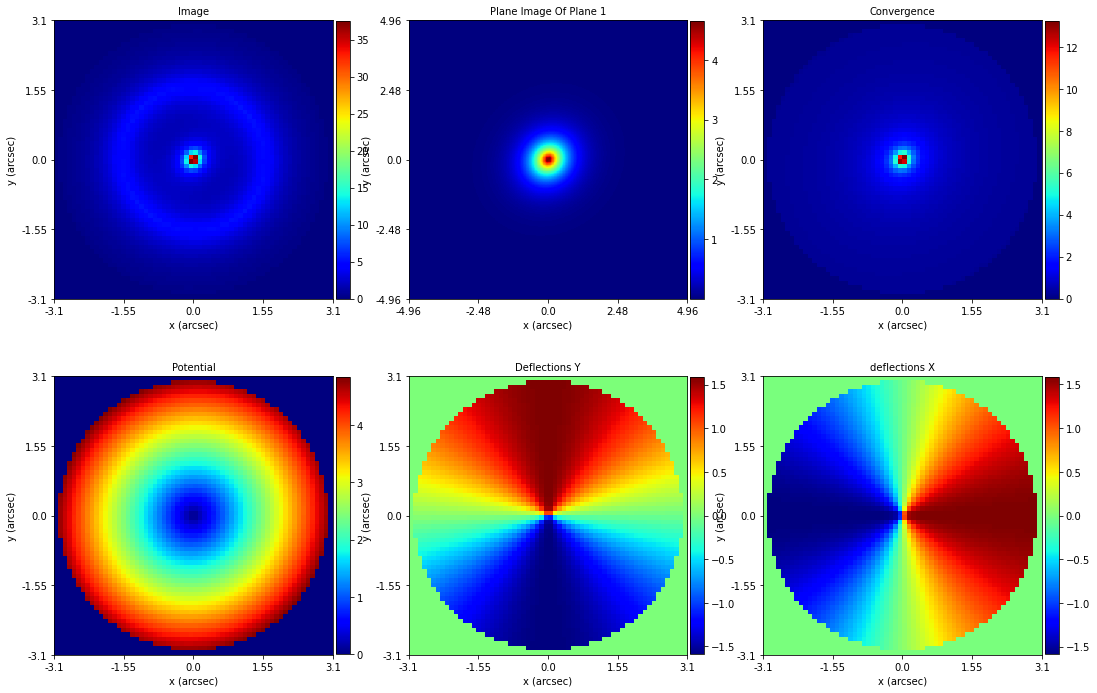

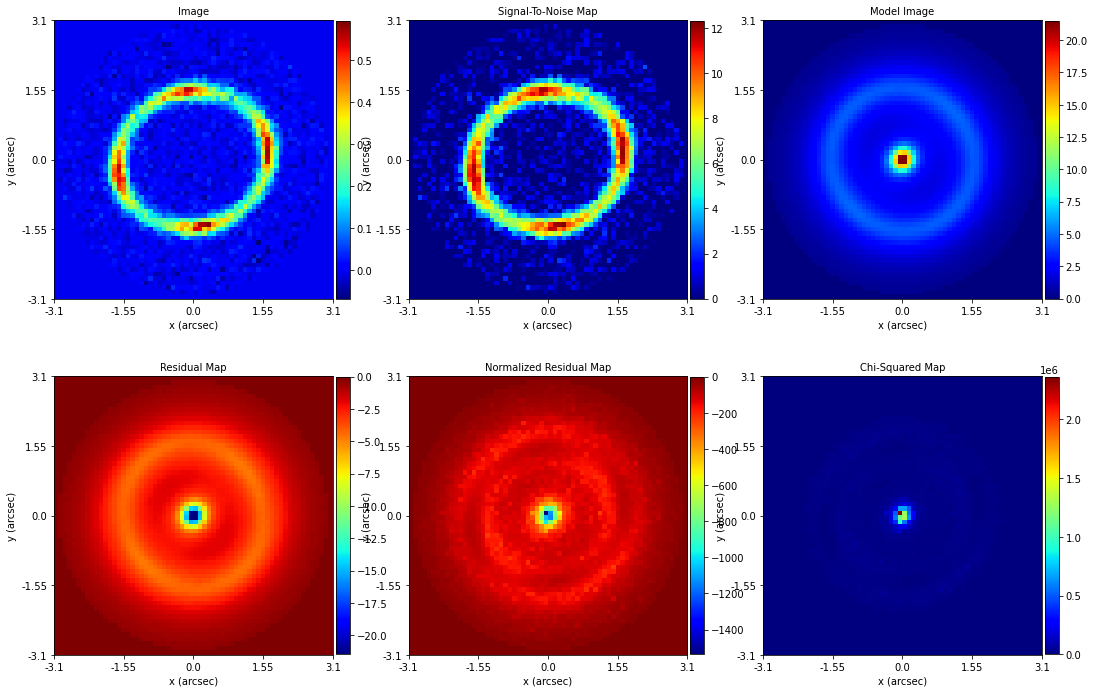

In [7]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=masked_imaging.grid
)
tracer_plotter.subplot_tracer()

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In fact, this ``Result`` object contains the full posterior information of our ``NonLinearSearch``, including all
parameter samples, log likelihood values and tools to compute the errors on the lens model.

The script `autolens_workspace/examples/mdoel/result.py` contains a full description of all information contained
in a ``Result``.